# Quickstart

In [1]:
from optiwindnet.importer import load_repository
from optiwindnet.svg import svgplot
from optiwindnet.interarraylib import G_from_S
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.pathfinding import PathFinder

In [2]:
locations = load_repository()

## Quickest (sub-second)

In [3]:
from optiwindnet.heuristics import EW_presolver

In [4]:
L = locations.doggerA

In [5]:
%%timeit
P, A = make_planar_embedding(L)

43.2 ms ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
P, A = make_planar_embedding(L)

In [7]:
%%timeit
S_pre = EW_presolver(A, capacity=8)

7.95 ms ± 608 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
S_pre = EW_presolver(A, capacity=8)

In [9]:
%%timeit
G_tentative = G_from_S(S_pre, A)
G_pre = PathFinder(G_tentative, planar=P, A=A).create_detours()

48.8 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
G_tentative = G_from_S(S_pre, A)
G_pre = PathFinder(G_tentative, planar=P, A=A).create_detours()

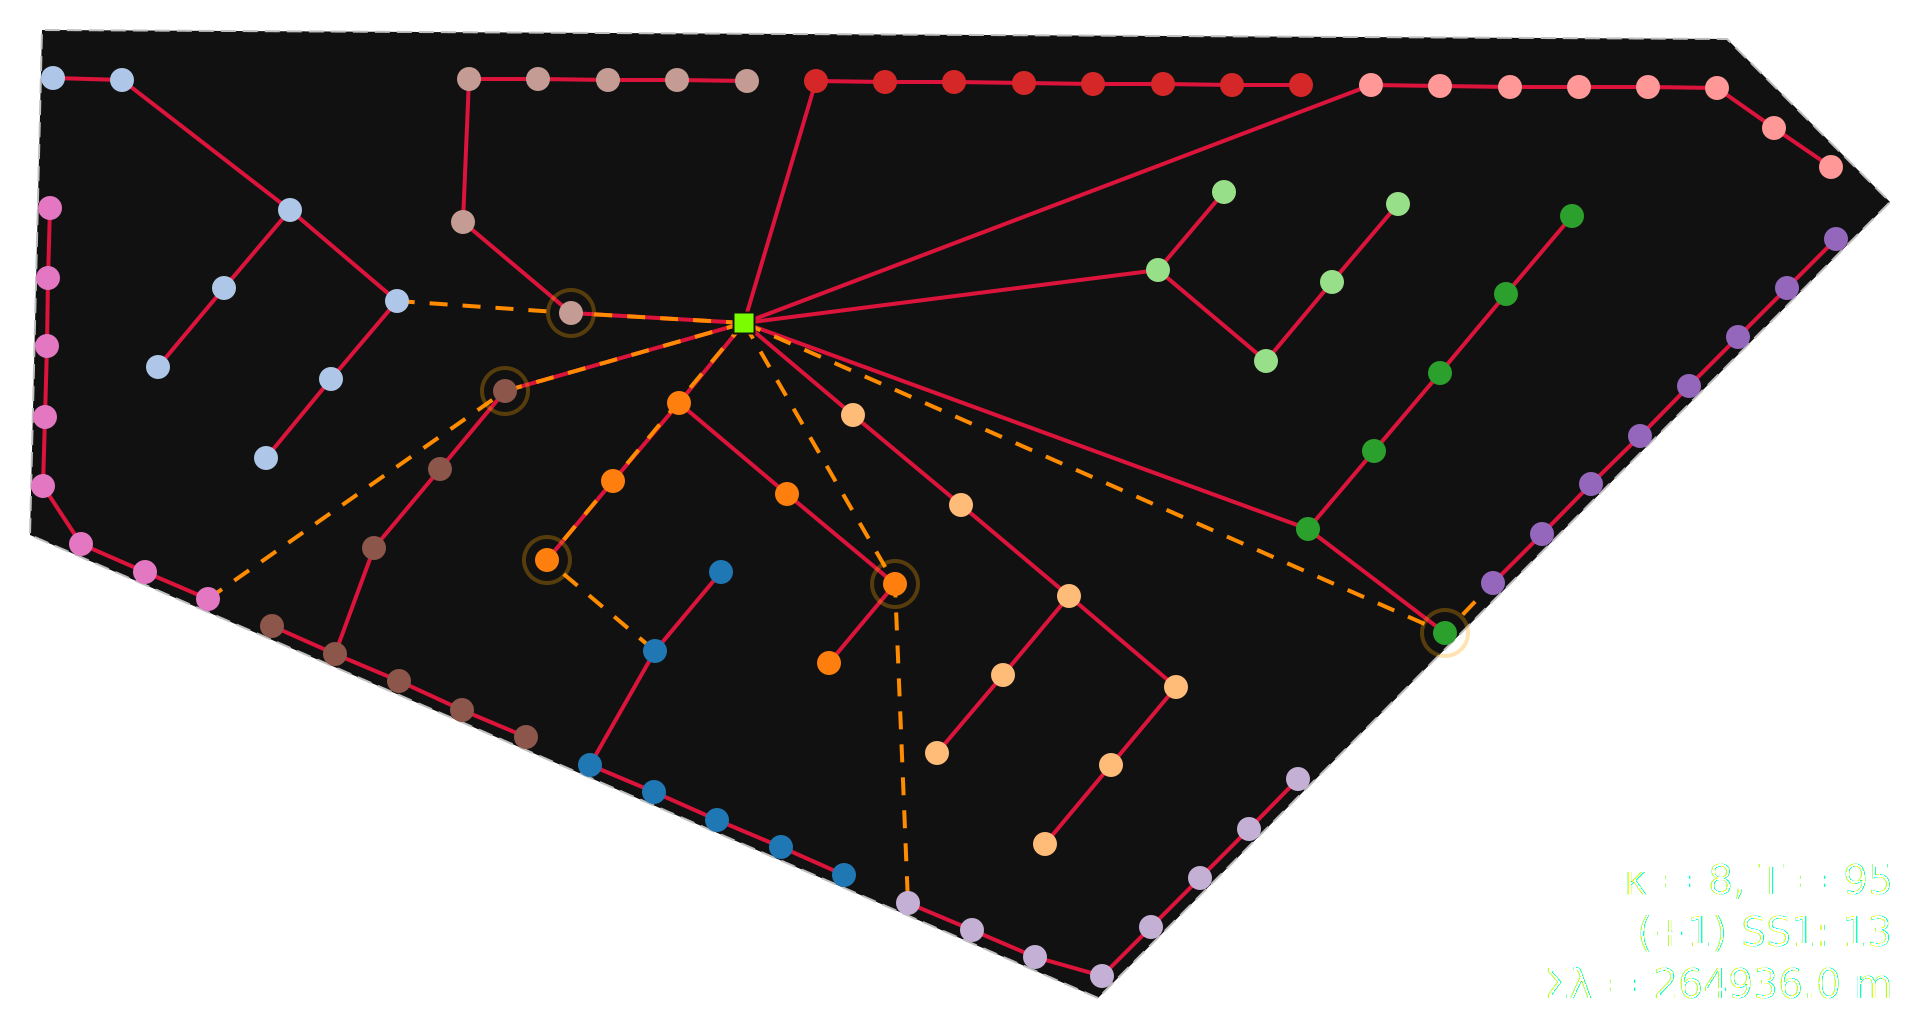

In [11]:
svgplot(G_pre)

## Quick (radial only, a second or two)

In [12]:
from optiwindnet.baselines.hgs import hgs_multiroot
from optiwindnet.interarraylib import as_normalized

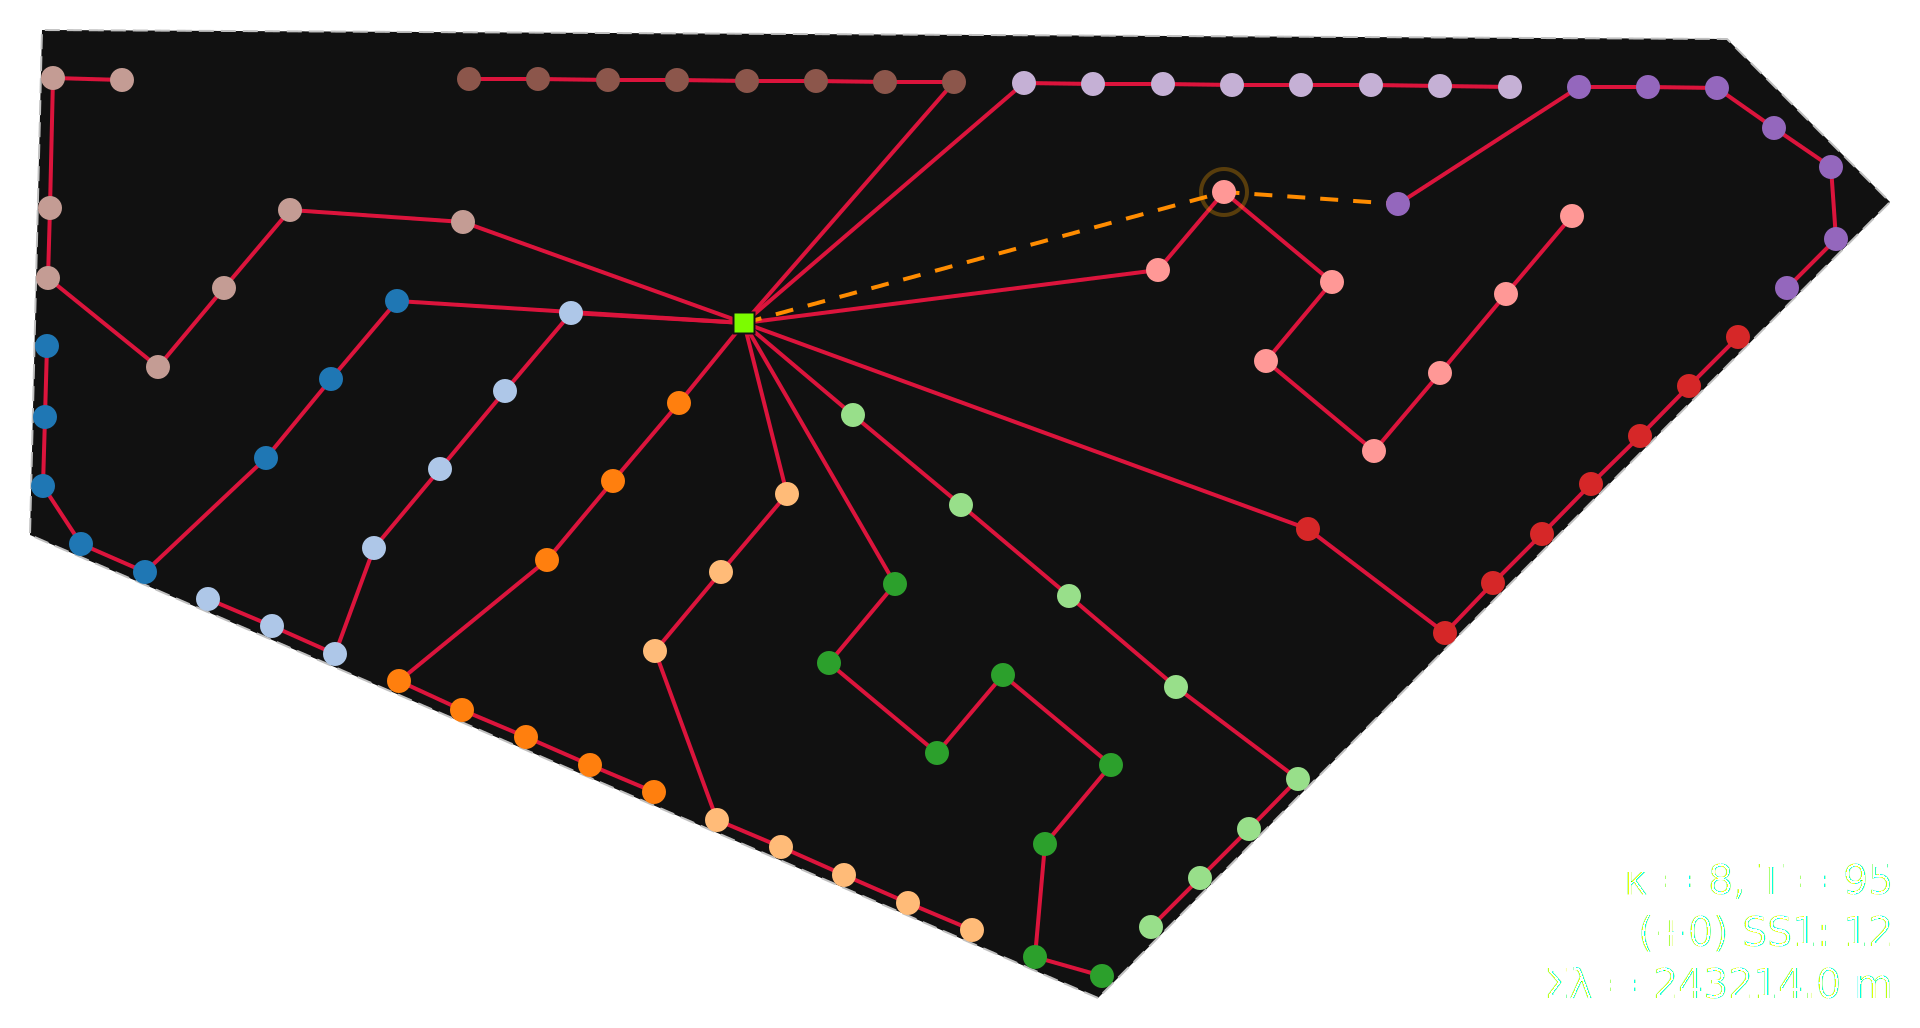

In [13]:
L = locations.doggerA
P, A = make_planar_embedding(L)
S_hgs = hgs_multiroot(as_normalized(A), capacity=8, time_limit=2)
G_tentative = G_from_S(S_hgs, A)
G_hgs = PathFinder(G_tentative, planar=P, A=A).create_detours()
svgplot(G_hgs)

## With quality assurance (a few minutes)

In [14]:
from optiwindnet.MILP import solver_factory, ModelOptions

In [15]:
solver = solver_factory('ortools')

In [16]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



In [17]:
solver.set_problem(
    P, A, S_hgs.graph['capacity'], ModelOptions(
        topology='branched',
        feeder_route='segmented',
        feeder_limit='unlimited'
    ), warmstart=S_hgs
)

In [18]:
# required to get the log inside the notebook (goes only to console otherwise)
solver.solver.log_callback = print

solver.solve(
    time_limit=40,
    mip_gap=0.005,
    verbose=True,
)


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 40 log_search_progress: true relative_gap_limit: 0.005
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0xd731f65355c953ec)
#Variables: 1'690 (#bools: 845 in floating point objective) (1'500 primary variables)
  - 845 Booleans in [0,1]
  - 750 in [0,7]
  - 95 in [0,8]
#kAtMostOne: 635 (#literals: 1'926)
#kLinear1: 1'690 (#enforced: 1'690)
#kLinear3: 4
#kLinearN: 284 (#terms: 4'213)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 845 terms with magnitude in [1409.66, 22631.9] average = 4594.28
[Scaling] Objective coefficient relative error: 1.60816e-10
[Scaling] Objective worst-case absolute error: 5.3597e-05
[Scaling] Objective scaling factor: 2.09715e+06
  1.77e-03s  0.00e+00d  [DetectDominanceRelations] 
  6.51e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_stre

SolutionInfo(runtime=40.070975000000004, bound=228785.35905271623, objective=240847.58781760104, relgap=0.05008241466806718, termination='FEASIBLE')

In [19]:
S, G = solver.get_solution()

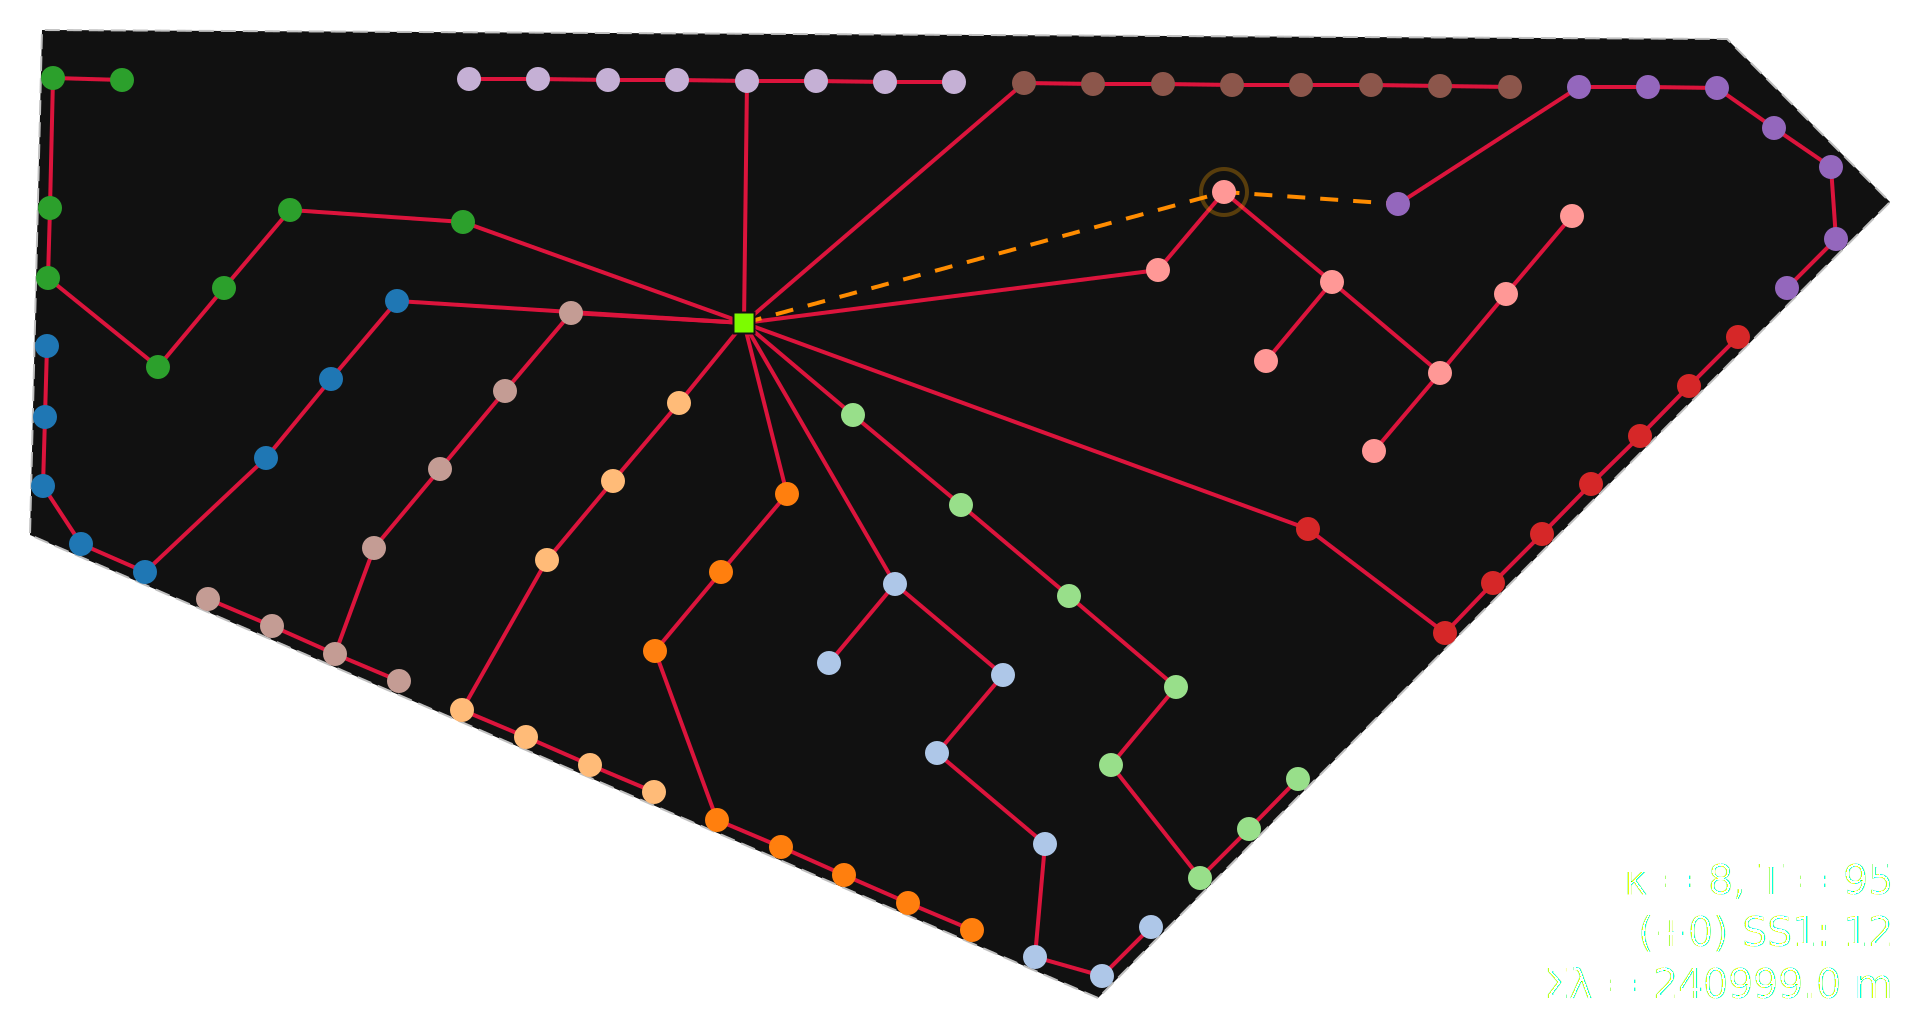

In [20]:
svgplot(G)